# NGC 346 infrared profiles

Broad slit profiles across the bow shock

In [205]:
from pathlib import Path
import numpy as np
import astropy.units as u
from astropy import constants
from mpdaf.obj import Image
from matplotlib import pyplot as plt
import seaborn as sns
import regions
import cmasher as cmr
sns.set_context("talk")
sns.set_color_codes()

In [8]:
irfiles = Path("../data").glob("ngc346-ir-*.fits")
irfiles = sorted(irfiles)
irfiles

[PosixPath('../data/ngc346-ir-0036-IRAC1.fits'),
 PosixPath('../data/ngc346-ir-0045-IRAC2.fits'),
 PosixPath('../data/ngc346-ir-0057-IRAC3.fits'),
 PosixPath('../data/ngc346-ir-0080-IRAC4.fits'),
 PosixPath('../data/ngc346-ir-0082-MSX-A.fits'),
 PosixPath('../data/ngc346-ir-0120-WISE3.fits'),
 PosixPath('../data/ngc346-ir-0121-MSX-C.fits'),
 PosixPath('../data/ngc346-ir-0146-MSX-D.fits'),
 PosixPath('../data/ngc346-ir-0214-MSX-E.fits'),
 PosixPath('../data/ngc346-ir-0221-WISE4.fits'),
 PosixPath('../data/ngc346-ir-0236-MIPS1.fits'),
 PosixPath('../data/ngc346-ir-0714-MIPS2.fits'),
 PosixPath('../data/ngc346-ir-1000-PACS-B.fits'),
 PosixPath('../data/ngc346-ir-1600-PACS-R.fits'),
 PosixPath('../data/ngc346-ir-2500-SPIRE250.fits'),
 PosixPath('../data/ngc346-ir-3500-SPIRE350.fits'),
 PosixPath('../data/ngc346-ir-5000-SPIRE500.fits')]

In [147]:
((0.2*u.arcsec)**2).to(u.sr).value

9.401772215639155e-13

For the SED, we want $\nu F_\nu$ in units of $L_\odot$:

In [221]:
Jy_micron_to_Lsun = (
    4.0 * np.pi * (61.7 * u.kpc)**2 * 1.0 * u.Jy 
    * (constants.c / (1.0*u.micron))
) / constants.L_sun
Jy_to_Lsun.cgs.value

356722.13313729496

In [234]:
Jy_micron_to_nuFnu = (
    1.0 * u.Jy 
    * (constants.c / (1.0*u.micron))
)
Jy_micron_to_nuFnu.cgs / Jy_to_Lsun.cgs

<Quantity 8.40408907e-15 g / s3>

In [222]:
class IRim:
    pixscale = 0.2
    
    def __init__(self, path, width=16.0):
        """IR image and associated E-W profile
        
        `width` is N-S width of profile in arcsec
        """
        self.path = path
        self.width = width
        self.im = Image(str(self.path))
        s = str(path).replace("../data/ngc346-ir-", "").replace(".fits", "")
        self.wav = np.round(0.1 * float(s[:4]), 1)
        self.label = s[5:]
        ny, nx = self.im.data.shape
        y0, dy = ny // 2, int(0.5 * self.width / self.pixscale)
        self.yslice = slice(y0 - dy, y0 + dy)
        self.profile = self.im.data[self.yslice, :].mean(axis=0)
        nx = len(profile)
        self.pos = self.pixscale * (np.arange(nx) - nx/2)
        self.bg = (self.profile[:50].mean() + self.profile[-50:].mean()) / 2
        self.profile -= self.bg
        self.im.data -= self.bg

    def eval_box_flux(self, xslice, xslices_bg):
        """BG-subtracted flux in box with uncertainties"""
        box = self.im.data[self.yslice, xslice]
        bgboxes = [self.im.data[self.yslice, _xslice] for _xslice in xslices_bg]
        bgmeans = [bgbox.mean() for bgbox in bgboxes]
        bgstds = [bgbox.std() for bgbox in bgboxes]
        npix = np.prod(box.shape)
        bgmean = np.mean(bgmeans)
        bgstd = np.mean(bgstds) # intra-box variation in BG
        bgstdi = np.std(bgmeans) # inter-box variation in BG
        boxmean = box.mean()
        pixel_area = ((self.pixscale * u.arcsec) ** 2).to(u.sr).value
        Jy_norm = npix * pixel_area * 1e6
        Jy_norm *= Jy_to_Lsun.cgs.value / self.wav
        self.boxflux = (boxmean - bgmean) * Jy_norm
        self.bgflux = bgmean * Jy_norm
        self.bgsig =  bgstd * Jy_norm
        self.bgsigi = bgstdi * Jy_norm

        
    def __repr__(self):
        return f"IRim({self.label}, {self.wav})"


In [223]:
irdata = {}
for path in sorted(irfiles):
    irim = IRim(path, 24)
    irim.eval_box_flux(
        slice(760, 800), 
        [slice(700, 750), slice(890, 940)],
    )
    irdata[irim.label] = irim
irdata

{'IRAC1': IRim(IRAC1, 3.6),
 'IRAC2': IRim(IRAC2, 4.5),
 'IRAC3': IRim(IRAC3, 5.7),
 'IRAC4': IRim(IRAC4, 8.0),
 'MSX-A': IRim(MSX-A, 8.2),
 'WISE3': IRim(WISE3, 12.0),
 'MSX-C': IRim(MSX-C, 12.1),
 'MSX-D': IRim(MSX-D, 14.6),
 'MSX-E': IRim(MSX-E, 21.4),
 'WISE4': IRim(WISE4, 22.1),
 'MIPS1': IRim(MIPS1, 23.6),
 'MIPS2': IRim(MIPS2, 71.4),
 'PACS-B': IRim(PACS-B, 100.0),
 'PACS-R': IRim(PACS-R, 160.0),
 'SPIRE250': IRim(SPIRE250, 250.0),
 'SPIRE350': IRim(SPIRE350, 350.0),
 'SPIRE500': IRim(SPIRE500, 500.0)}

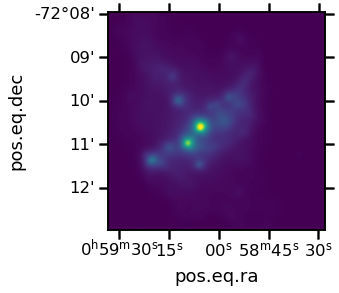

In [141]:
irdata["WISE3"].im.plot(vmin=0.0, vmax=35.0, use_wcs=True)

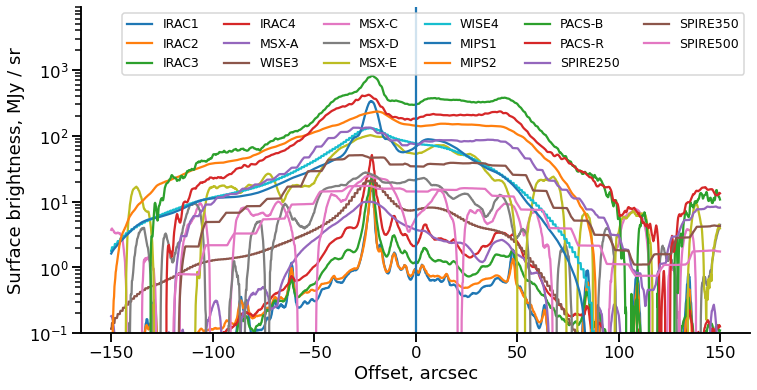

In [142]:
fig, ax = plt.subplots(figsize=(12, 6))
for irim in irdata.values():
    ax.plot(irim.pos, irim.profile, label=irim.label)
ax.legend(ncol=6, fontsize="x-small")
ax.axvline(0.0)
ax.set(
    xlabel="Offset, arcsec",
    ylabel="Surface brightness, MJy / sr",
    yscale="log",
    ylim=[0.1, 9000],
)
sns.despine();

In [143]:
goodbands = "WISE3", "MSX-E", "MSX-C", "WISE4", "MIPS1"

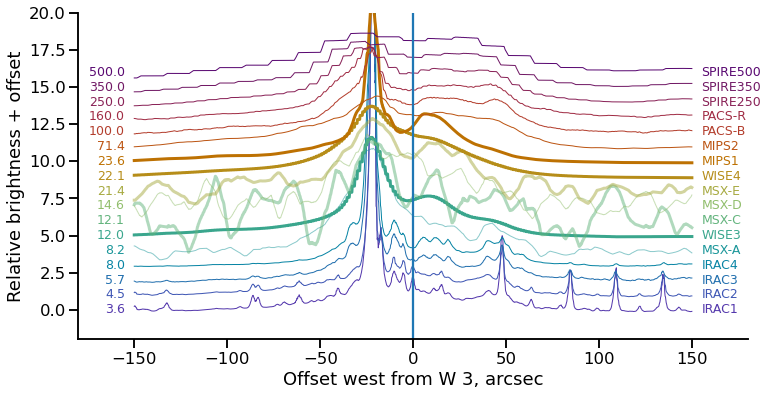

In [200]:
fig, ax = plt.subplots(figsize=(12, 6))
# Take N colors from named colormap in [0.15, 0.85] range in HEX
colors = cmr.take_cmap_colors(
    'cmr.infinity', 
    len(irdata), 
    cmap_range=(0.1, 1.0), 
    return_fmt='hex'
)
offset = 0.0
for irim, color in zip(irdata.values(), colors):
    lw = 3.0 if irim.label in goodbands else 1.0
    alpha = 0.5 if "MSX" in irim.label else 1.0
    norm = np.mean(irim.profile.data)
    ax.plot(irim.pos, offset + irim.profile / norm, color=color, lw=lw, alpha=alpha)
    ax.text(155.0, offset, irim.label, va="center", fontsize="x-small", color=color)
    ax.text(-155.0, offset, f"{irim.wav:.1f}", ha="right", va="center", fontsize="x-small", color=color)
    offset += 1.0
#ax.legend(ncol=6, fontsize="x-small")
ax.axvline(0.0)
ax.set(
    xlabel="Offset west from W 3, arcsec",
    ylabel="Relative brightness + offset",
    yscale="linear",
    ylim=[-2.0, 3.0 + offset],
    xlim=[-180, 180],
)
sns.despine()
fig.savefig("../figs/ngc346-infrared-profiles.pdf");

In [172]:
x = irdata["IRAC1"]
x.boxflux, x.bgflux, x.bgsig, x.bgsigi

(0.0007323239163329687,
 0.0039050467642744637,
 0.0023854764964119086,
 0.0016074589548282002)

In [235]:
from astropy.modeling.blackbody import blackbody_lambda

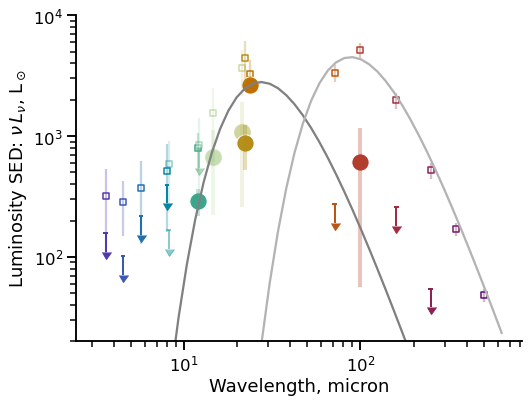

In [265]:
fig, ax = plt.subplots(figsize=(8, 6))
for irim, color in zip(irdata.values(), colors):
    ebg = np.hypot(irim.bgsig, irim.bgsigi)
    alpha = 0.5 if "MSX" in irim.label else 1.0
    ax.errorbar(irim.wav, irim.bgflux, yerr=ebg, color=color, alpha=0.3*alpha)
    ax.scatter(irim.wav, irim.bgflux, color="w", marker="s", s=30, edgecolors=color, alpha=alpha)
    eflux = 0.7 * irim.bgsig
    if irim.boxflux > eflux:
        ax.errorbar(
            irim.wav, irim.boxflux,
            yerr=eflux,
            color=color, lw=4, alpha=0.3*alpha,
        )
        ax.scatter(irim.wav, irim.boxflux, 
                   marker="o", color=color, s=300,
                   edgecolors="w", linewidth=1, alpha=alpha,
                  )
    else:
        ax.errorbar(irim.wav, irim.boxflux + eflux,
                    xerr=0.03*irim.wav, yerr=0.3*(irim.boxflux + eflux), uplims=True, 
                    linewidth=2, color=color, alpha=alpha)
        
beta = 1.3
wavgrid = np.logspace(0.5, 2.8)
bb = wavgrid * blackbody_lambda(wavgrid * u.micron, 100 * u.K)
bb *= wavgrid ** (-beta)
bb /= bb.max()
bb *= 2800

bb2 = wavgrid * blackbody_lambda(wavgrid * u.micron, 31 * u.K)
bb2 *= wavgrid ** (-beta)
bb2 /= bb2.max()
bb2 *= 4500

ax.plot(wavgrid, bb, color="0.5")
ax.plot(wavgrid, bb2, color="0.7")


ax.set_xscale("log")
ax.set_yscale("log")
ax.set(
    xlabel="Wavelength, micron",
    ylabel=r"Luminosity SED: $\nu\, L_\nu$, L$_\odot$",
    ylim=[20.0, 1e4],
)
sns.despine()
fig.savefig("../figs/ngc346-infrared-sed.pdf");

In [266]:
u.Jy.cgs

Unit("1e-23 g / s2")

Convert back to Jy

In [284]:
irdata["MIPS1"].boxflux * irdata["MIPS1"].wav / Jy_to_Lsun.cgs.value

0.17469715619331413

In [283]:
irdata["WISE3"].boxflux * irdata["WISE3"].wav / Jy_to_Lsun.cgs.value

0.00976149803791932

Use the method of Paper III eq (3) to find luminosity.  Since we don't have any 60 micron flux, we have a bolometric flux of 

In [280]:
Fbol = 1e-10 * (
    2.4 * irdata["WISE3"].boxflux * irdata["WISE3"].wav
    + 1.6 * irdata["MIPS1"].boxflux * irdata["MIPS1"].wav
) / Jy_to_Lsun.cgs.value
Fbol * u.erg / u.s / u.cm ** 2

<Quantity 3.02943045e-11 erg / (cm2 s)>

In [281]:
Lbol = 4.0 * np.pi * (61.7 * u.kpc)**2 * Fbol * u.erg / u.s / u.cm ** 2
Lbol.cgs

<Quantity 1.37988302e+37 erg / s>

In [282]:
Lbol.cgs / constants.L_sun.cgs

<Quantity 3604.71007256>

In [279]:
irdata["MIPS1"].boxflux

2640.607720775348

So that is consistent: we have a bolometric shell luminosity of 3600 Lsun.  The stellar luminosity is beleieved to be about 1e6 Lsun, so we have

In [286]:
tau = 2 * (Lbol.cgs / constants.L_sun.cgs).value / 1e6
tau

0.00720942014511667

That is right in the middle of the pack compared with the other sources in Paper III

We have R = 1.2 pc approx, so by eq (5) we have

In [287]:
U = 14.7 * 100 / 1.2**2 
U

1020.8333333333334

Figure 3 of Paper III shows dust temperature of order 100 K, which is consistent with what we derive from the SED.

Now we can use eq (2) to find η.  I assume $h_{1/4} = 4$ because the shell is really quite thick

In [289]:
eta = 245 * 1.2 * 1.3 * tau / (100 * 1.0 * 4.0)
eta

0.0068886009486589786

Wow, so that means the shell may well be radiation supported.  But if $\kappa < 600$ cm2/g then eta would be larger and we might be wind-supported.